In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns # for visualiation
from sklearn.pipeline import make_pipeline  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV  
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

import altair as alt
alt.renderers.enable('notebook') # enable altair rendering

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the provided data
train_features = pd.read_csv('data/dengue_features_train.csv')
train_labels = pd.read_csv('data/dengue_labels_train.csv')

In [3]:
# Seperate data for San Juan
sj_train_features = train_features[train_features.city=='sj'].drop(["city", "weekofyear", "week_start_date", "year"], axis = 1)
sj_train_labels = train_labels[train_features.city=='sj'].drop(["city", "weekofyear", "year"], axis = 1)

# Separate data for Iquitos
iq_train_features = train_features[train_features.city=='iq'].drop(["city", "weekofyear", "week_start_date", "year"], axis = 1)
iq_train_labels = train_labels[train_features.city=='iq'].drop(["city", "weekofyear", "year"], axis = 1)

# Filling in the empty values with the last valid value
sj_train_features.fillna(method = 'ffill', inplace = True)
iq_train_features.fillna(method = 'ffill', inplace = True)

# Create New Feature

In A3, we decided to have a lag variable to track the difference in average temperature throughout every week. In A4, we decided to track the difference in max temperature and average temperature instead of having a 1 week delay. We tracked the change in temperature because the incubation period of the virus shortens in warmer temperatures, which means a mosquito doesn’t have to survive as long to have a chance of becoming infectious. 

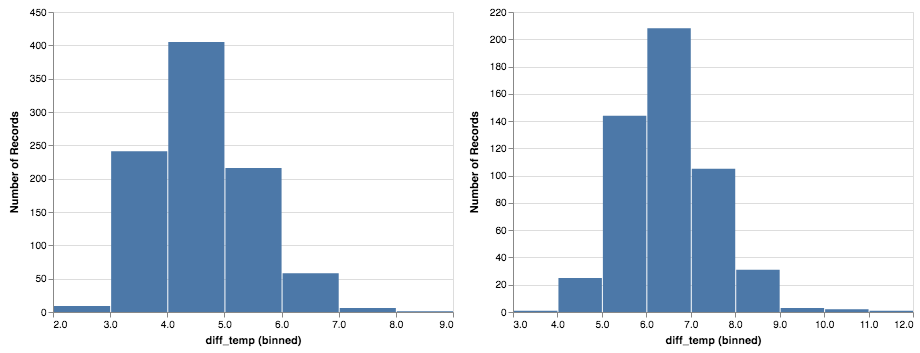

In [4]:
diff_temp = sj_train_features['station_max_temp_c'] - sj_train_features['station_avg_temp_c']
sj_train_features['diff_temp'] = diff_temp
diff_temp = iq_train_features['station_max_temp_c'] - iq_train_features['station_avg_temp_c']
iq_train_features['diff_temp'] = diff_temp
sj_diff_temp_alt = alt.Chart(sj_train_features).mark_bar().encode(
    alt.X("diff_temp:Q", bin=True),
    y='count()',
)
iq_diff_temp_alt = alt.Chart(iq_train_features).mark_bar().encode(
    alt.X("diff_temp:Q", bin=True),
    y='count()',
)
sj_diff_temp_alt | iq_diff_temp_alt

# Models
List of machine learning models used:
- KNeighborsRegressor
- RandomForestRegressor
- GradientBoostingRegressor
- Support Vector Regression

## Training and Testing: A Tale of Two Cities
Split the data into training and testing for both cities using a 20% size split.

In [5]:
sj_train_features_sub, sj_test_features_sub, sj_train_outcome, sj_test_outcome = train_test_split(
    sj_train_features,
    sj_train_labels,
    test_size=0.20
)
iq_train_features_sub, iq_test_features_sub, iq_train_outcome, iq_test_outcome = train_test_split(
    iq_train_features,
    iq_train_labels,
    test_size=0.20
)

## KNeighborsRegressor 

In [6]:
knn_reg = KNeighborsRegressor()
pipe = make_pipeline(PolynomialFeatures(), VarianceThreshold(.1), StandardScaler(), knn_reg)
param_grid = {'polynomialfeatures__degree':range(1, 4),
              'kneighborsregressor__n_neighbors':range(1, 10), 
              'kneighborsregressor__weights':["uniform", "distance"]}

grid_sj = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")
grid_sj.fit(sj_train_features_sub, sj_train_outcome)
sj_score_knn = grid_sj.score(sj_test_features_sub, sj_test_outcome)
sj_pred_knn = grid_sj.predict(sj_test_features_sub)

grid_iq = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")
grid_iq.fit(iq_train_features_sub, iq_train_outcome)
iq_score_knn = grid_iq.score(iq_test_features_sub, iq_test_outcome)
iq_pred_knn = grid_iq.predict(iq_test_features_sub)

In [7]:
print("sj error: ", sj_score_knn)
print("iq error: ", iq_score_knn)

sj error:  -27.059070499671275
iq error:  -6.8931623931623935


## RandomForestRegressor

In [8]:
rf = RandomForestRegressor()
param_grid = {
    'max_features': range(5,10),
    'min_samples_leaf': range(1,5),
    'min_samples_split': range(2,5),
    'n_estimators': range(10,100,10)
}

grid_search_sj = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, scoring="neg_mean_absolute_error")
grid_search_sj.fit(sj_train_features_sub, sj_train_outcome)
sj_score_rf = grid_search_sj.score(sj_test_features_sub, sj_test_outcome)
sj_pred_rf = grid_search_sj.predict(sj_test_features_sub)

grid_search_iq = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, scoring="neg_mean_absolute_error")
grid_search_iq.fit(iq_train_features_sub, iq_train_outcome)
iq_score_rf = grid_search_iq.score(iq_test_features_sub, iq_test_outcome)
iq_pred_rf = grid_search_iq.predict(iq_test_features_sub)

In [9]:
print("sj error: ", sj_score_rf)
print("iq error: ", iq_score_rf)

sj error:  -22.6265381612646
iq error:  -7.119905515769743


## GradientBoostingRegressor

In [10]:
from sklearn import preprocessing
sj_train_scaled = preprocessing.scale(sj_train_features_sub)
iq_train_scaled = preprocessing.scale(iq_train_features_sub)
sj_test_scaled = preprocessing.scale(sj_test_features_sub)
iq_test_scaled = preprocessing.scale(iq_test_features_sub)
gb_reg = GradientBoostingRegressor()
param_grid = {
    'n_estimators': [200,350,500,700], 
    'max_depth': range(1,6), 
    'learning_rate': [0.1, 0.01], 
    'loss': ['ls','lad']
}

grid_search_gb_sj = GridSearchCV(estimator = gb_reg, param_grid = param_grid, cv = 3, scoring="neg_mean_absolute_error")
grid_search_gb_sj.fit(sj_train_scaled, sj_train_outcome)
sj_score_gb = grid_search_gb_sj.score(sj_test_scaled, sj_test_outcome)
sj_pred_gb = grid_search_gb_sj.predict(sj_test_scaled)

grid_search_gb_iq = GridSearchCV(estimator = gb_reg, param_grid = param_grid, cv = 3, scoring="neg_mean_absolute_error")
grid_search_gb_iq.fit(iq_train_scaled, iq_train_outcome)
iq_score_gb = grid_search_gb_iq.score(iq_test_scaled, iq_test_outcome)
iq_pred_gb = grid_search_gb_iq.predict(iq_test_scaled)

In [11]:
print("sj error: ", sj_score_gb)
print("iq error: ", iq_score_gb)

sj error:  -21.960280077855796
iq error:  -6.142847887127865


# SupportVectorRegresor

In [13]:
from sklearn import preprocessing
sj_train_scaled = preprocessing.scale(sj_train_features_sub)
iq_train_scaled = preprocessing.scale(iq_train_features_sub)
sj_test_scaled = preprocessing.scale(sj_test_features_sub)
iq_test_scaled = preprocessing.scale(iq_test_features_sub)

param_grid = {
    'kernel': ['linear'],
    'C':  np.arange(1, 15.0, 0.5)}

# train and test sj data
grid_search_svr_sj = GridSearchCV(SVR(), param_grid, scoring="neg_mean_absolute_error")
grid_search_svr_sj.fit(sj_train_scaled, sj_train_outcome)
sj_score_svr = grid_search_svr_sj.score(sj_test_scaled, sj_test_outcome)
sj_pred_svr = grid_search_svr_sj.predict(sj_test_scaled)

# taind and test iq data
grid_search_svr_iq = GridSearchCV(SVR(), param_grid, scoring="neg_mean_absolute_error")
grid_search_svr_iq.fit(iq_train_scaled, iq_train_outcome)
iq_score_svr = grid_search_svr_iq.score(iq_test_scaled, iq_test_outcome)
iq_pred_svr = grid_search_svr_iq.predict(iq_test_scaled)

In [14]:
print("sj error: ", sj_score_svr)
print("iq error: ", iq_score_svr)

sj error:  -22.22365579122446
iq error:  -6.276192518255886


# Visualizations

## Comparison of the accuracy across the models

(array([ 8., 97., 59., 17.,  1.,  0.,  2.,  1.,  0.,  3.]),
 array([-85.51740909, -47.27136445,  -9.02531982,  29.22072482,
         67.46676945, 105.71281408, 143.95885872, 182.20490335,
        220.45094799, 258.69699262, 296.94303726]),
 <a list of 10 Patch objects>)

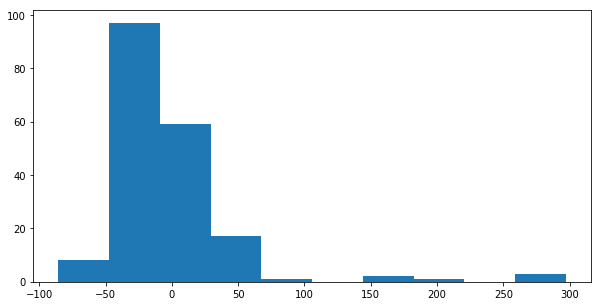

In [18]:
# KNN, SJ

# vis dataframe for knn model
vis_sj_knn = sj_test_features_sub.join(sj_test_outcome)
vis_sj_knn['preds'] = sj_pred_knn
vis_sj_knn['error'] = vis_sj_knn.total_cases - vis_sj_knn.preds

plt.figure(figsize=(10, 5))
plt.hist(vis_sj_knn.error)

(array([  1.,   7., 133.,  34.,   6.,   1.,   2.,   2.,   0.,   2.]),
 array([-102.32394135,  -65.17686576,  -28.02979017,    9.11728542,
          46.26436101,   83.4114366 ,  120.55851219,  157.70558778,
         194.85266337,  231.99973896,  269.14681455]),
 <a list of 10 Patch objects>)

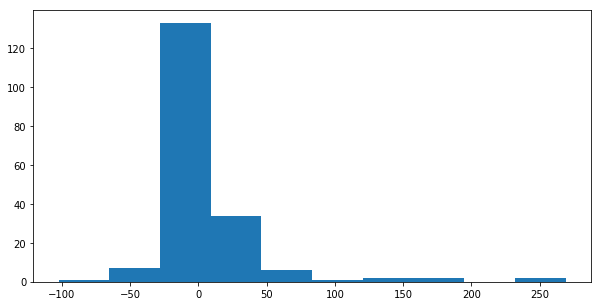

In [19]:
# Random Forest, SJ

# vis dataframe for random forest model
vis_sj_gb = sj_test_features_sub.join(sj_test_outcome)
vis_sj_gb['preds'] = sj_pred_gb
vis_sj_gb['error'] = vis_sj_gb.total_cases - vis_sj_gb.preds

plt.figure(figsize=(10, 5))
plt.hist(vis_sj_gb.error)

(array([ 5., 37., 98., 29., 11.,  3.,  1.,  2.,  0.,  2.]),
 array([-77.02554628, -50.08602226, -23.14649825,   3.79302577,
         30.73254978,  57.6720738 ,  84.61159781, 111.55112183,
        138.49064585, 165.43016986, 192.36969388]),
 <a list of 10 Patch objects>)

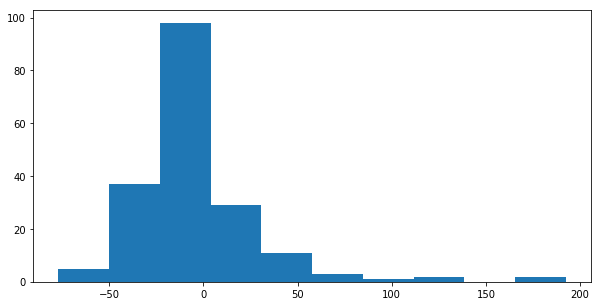

In [20]:
# Gradient Boosting, SJ

# vis dataframe for gradient boosting model
vis_sj_rf = sj_test_features_sub.join(sj_test_outcome)
vis_sj_rf['preds'] = sj_pred_rf
vis_sj_rf['error'] = vis_sj_rf.total_cases - vis_sj_rf.preds

plt.figure(figsize=(10, 5))
plt.hist(vis_sj_rf.error)

(array([133.,  43.,   5.,   1.,   2.,   1.,   0.,   1.,   0.,   2.]),
 array([-31.54139675,   9.85149215,  51.24438104,  92.63726993,
        134.03015882, 175.42304772, 216.81593661, 258.2088255 ,
        299.6017144 , 340.99460329, 382.38749218]),
 <a list of 10 Patch objects>)

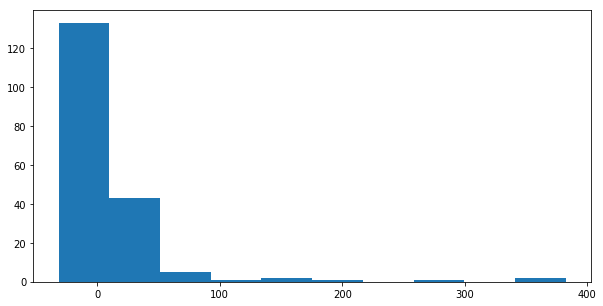

In [21]:
# Support Vector, SJ

# vis dataframe for suppoort vector model
vis_sj_svr = sj_test_features_sub.join(sj_test_outcome)
vis_sj_svr['preds'] = sj_pred_svr
vis_sj_svr['error'] = vis_sj_svr.total_cases - vis_sj_svr.preds

plt.figure(figsize=(10, 5))
plt.hist(vis_sj_svr.error)

(array([ 8., 56., 27.,  7.,  4.,  0.,  0.,  0.,  1.,  1.]),
 array([-1.90000000e+01, -9.47777778e+00,  4.44444444e-02,  9.56666667e+00,
         1.90888889e+01,  2.86111111e+01,  3.81333333e+01,  4.76555556e+01,
         5.71777778e+01,  6.67000000e+01,  7.62222222e+01]),
 <a list of 10 Patch objects>)

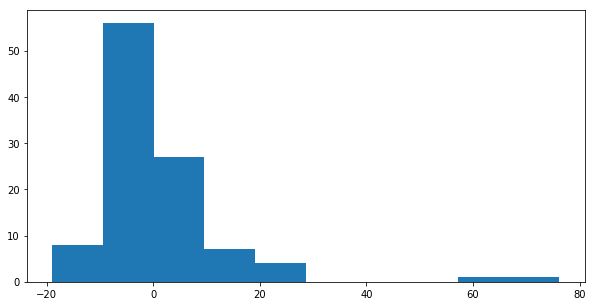

In [22]:
# KNN, IQ

# vis dataframe for knn model
vis_iq_knn = iq_test_features_sub.join(iq_test_outcome)
vis_iq_knn['preds'] = iq_pred_knn
vis_iq_knn['error'] = vis_iq_knn.total_cases - vis_iq_knn.preds

plt.figure(figsize=(10, 5))
plt.hist(vis_iq_knn.error)

(array([17., 62., 13.,  7.,  3.,  0.,  0.,  0.,  1.,  1.]),
 array([-15.86763969,  -6.89523925,   2.07716118,  11.04956161,
         20.02196204,  28.99436248,  37.96676291,  46.93916334,
         55.91156378,  64.88396421,  73.85636464]),
 <a list of 10 Patch objects>)

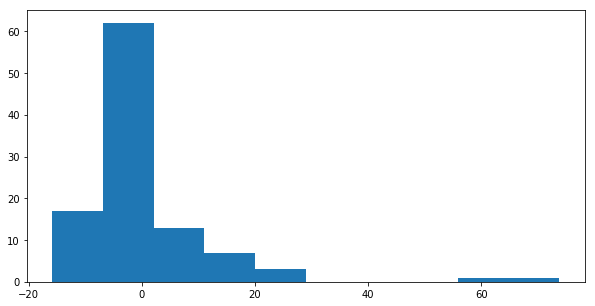

In [23]:
# Random Forest, IQ

# vis dataframe for random forest model
vis_iq_rf = iq_test_features_sub.join(iq_test_outcome)
vis_iq_rf['preds'] = iq_pred_rf
vis_iq_rf['error'] = vis_iq_rf.total_cases - vis_iq_rf.preds

plt.figure(figsize=(10, 5))
plt.hist(vis_iq_rf.error)

(array([63., 25.,  9.,  4.,  1.,  0.,  0.,  1.,  0.,  1.]),
 array([-6.55300801,  1.74699199, 10.04699199, 18.34699199, 26.64699199,
        34.94699199, 43.24699199, 51.54699199, 59.84699199, 68.14699199,
        76.44699199]),
 <a list of 10 Patch objects>)

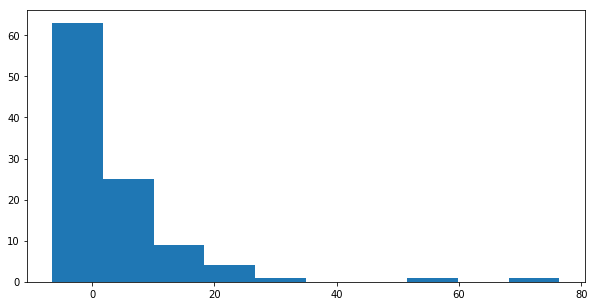

In [24]:
# Gradient Boosting, IQ

# vis dataframe for gradient boosting model
vis_iq_gb = iq_test_features_sub.join(iq_test_outcome)
vis_iq_gb['preds'] = iq_pred_gb
vis_iq_gb['error'] = vis_iq_gb.total_cases - vis_iq_gb.preds

plt.figure(figsize=(10, 5))
plt.hist(vis_iq_gb.error)

(array([45., 42.,  9.,  4.,  2.,  0.,  0.,  1.,  0.,  1.]),
 array([-9.21415594, -0.58317234,  8.04781126, 16.67879486, 25.30977846,
        33.94076206, 42.57174566, 51.20272926, 59.83371286, 68.46469647,
        77.09568007]),
 <a list of 10 Patch objects>)

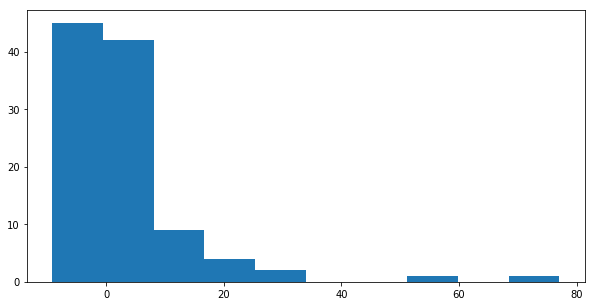

In [25]:
# Support Vector, IQ

# vis dataframe for gradient boosting model
vis_iq_svr = iq_test_features_sub.join(iq_test_outcome)
vis_iq_svr['preds'] = iq_pred_svr
vis_iq_svr['error'] = vis_iq_svr.total_cases - vis_iq_svr.preds

plt.figure(figsize=(10, 5))
plt.hist(vis_iq_svr.error)

## Comparison of predicted value and the actual value

### San Juan data

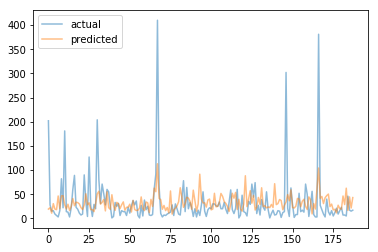

In [26]:
# KNN
actual_sj = sj_test_outcome.values
plt.plot(actual_sj, alpha=.5,label = "actual")
plt.plot(sj_pred_knn, alpha=.5, label = "predicted")
plt.legend()

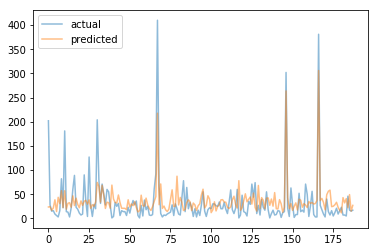

In [27]:
# Random Forest
plt.plot(actual_sj, alpha=.5, label = "actual")
plt.plot(sj_pred_rf, alpha=.5, label = "predicted")
plt.legend()

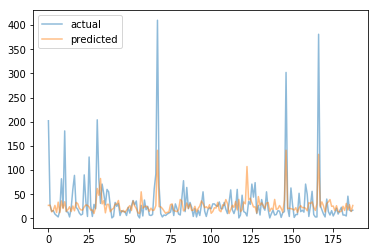

In [28]:
# GB
plt.plot(actual_sj, alpha=.5, label = "actual")
plt.plot(sj_pred_gb, alpha=.5, label = "predicted")
plt.legend()

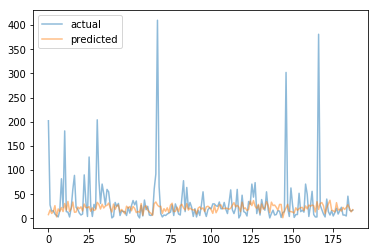

In [29]:
# SVR
plt.plot(actual_sj, alpha=.5, label = "actual")
plt.plot(sj_pred_svr, alpha=.5, label = "predicted")
plt.legend()

### Iquitos data

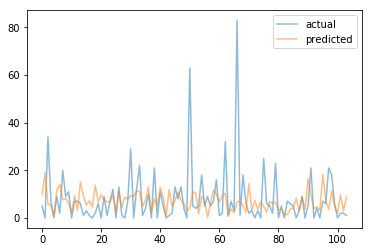

In [30]:
# KNN
actual_iq = iq_test_outcome.values
plt.plot(actual_iq, alpha=.5, label = "actual")
plt.plot(iq_pred_knn, alpha=.5, label = "predicted")
plt.legend()

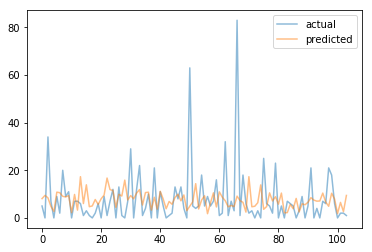

In [31]:
# Random Forest
plt.plot(actual_iq, alpha=.5, label = "actual")
plt.plot(iq_pred_rf, alpha=.5, label = "predicted")
plt.legend()

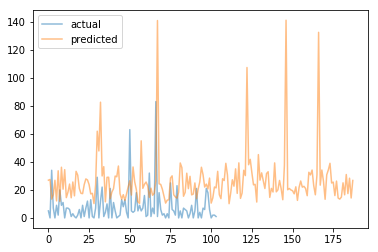

In [32]:
# GB
plt.plot(actual_iq, alpha=.5, label = "actual")
plt.plot(sj_pred_gb, alpha=.5, label = "predicted")
plt.legend()

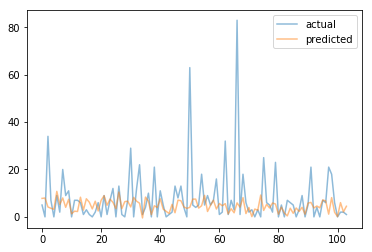

In [33]:
# SVR
plt.plot(actual_iq, alpha=.5, label = "actual")
plt.plot(iq_pred_svr, alpha=.5, label = "predicted")
plt.legend()

## Assessing the performance for different parameters

Looking at the visualizations and based on the mean error caculated in the section above, we think Support Vector Regresor is our most accurate model. We'll evaluate some of the parameters in this model. 

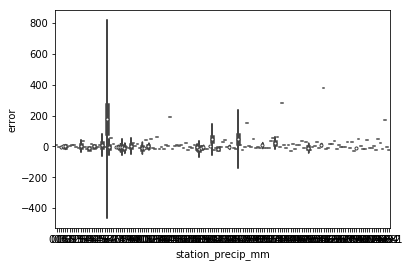

In [34]:
# station_precip_mm, sj

sns.violinplot(y="error", x="station_precip_mm", data=vis_sj_svr)

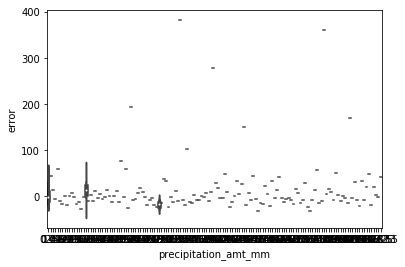

In [35]:
# precipitation_amt_mm, sj

sns.violinplot(y="error", x="precipitation_amt_mm", data=vis_sj_svr)

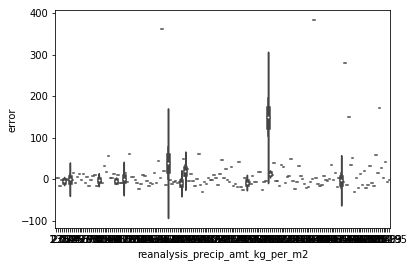

In [36]:
# reanalysis_precip_amt_kg_per_m2, sj

sns.violinplot(y="error", x="reanalysis_precip_amt_kg_per_m2", data=vis_sj_svr)

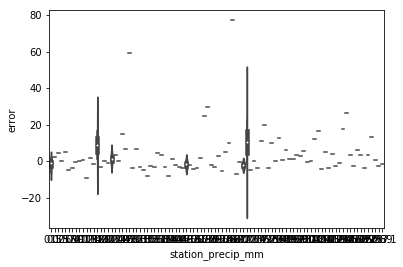

In [37]:
# station_precip_mm, iq

sns.violinplot(y="error", x="station_precip_mm", data=vis_iq_svr)

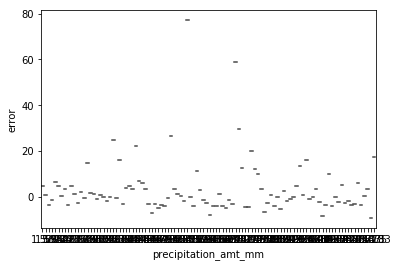

In [38]:
# precipitation_amt_mm, iq

sns.violinplot(y="error", x="precipitation_amt_mm", data=vis_iq_svr)

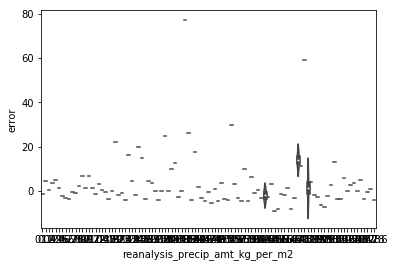

In [39]:
# reanalysis_precip_amt_kg_per_m2, iq

sns.violinplot(y="error", x="reanalysis_precip_amt_kg_per_m2", data=vis_iq_svr)

# Load test data

In [40]:
test_data = pd.read_csv('data/dengue_features_test.csv')

# SJ data
test_sj = test_data[test_data.city == 'sj'].copy()

test_sj = test_sj.drop(columns=["city", "weekofyear", "week_start_date", "year"])

test_sj.fillna(method = 'ffill', inplace = True)

diff_temp = test_sj['station_max_temp_c'] - test_sj['station_avg_temp_c']
test_sj['diff_temp'] = diff_temp

# IQ data
test_iq = test_data[test_data.city == 'iq'].copy()

test_iq = test_iq.drop(columns=["city", "weekofyear", "week_start_date", "year"])

test_iq.fillna(method = 'ffill', inplace = True)

diff_temp = test_iq['station_max_temp_c'] - test_iq['station_avg_temp_c']
test_iq['diff_temp'] = diff_temp

In [41]:
# SVR

sj_gb_result = grid_search_svr_sj.predict(test_sj).astype(int)

iq_gb_result = grid_search_svr_iq.predict(test_iq).astype(int)

result_svr = pd.read_csv('data/submission_format.csv')

result_svr.total_cases = np.concatenate([sj_gb_result, iq_gb_result])

result_svr.to_csv('data/predicted_svr.csv', index=False)